# How icy is sun, how fiery is snow? Playing with word embedding

We all know old, good and hackneyed examples, that are typically used to intuitively explain, what the **word embedding** technique is. We almost always come across a chart presenting a simplified, 2-dimensional vector representation of words **queen** and **king**, which are distant from each other in the similar length as words **woman** and **man**. 

Today, I'd like to go one step further and explore the meaning of the distance between two arbitrary selected vectors. It this particular case - distance between **ice** and **fire**.

## Motivation

Assume for the moment we have as embedding in the 2-dimensional space. It's not a realistic case, because in most cases such low-dimensional embedding wouldn't fulfill its purpose. So, we have a bunch of vectors or points, described with two coordinates. We choose two such vectors, say **ice** and **fire**, as mentioned above.

![Drawn using https://www.geogebra.org/m/JMMKv7cx](plot_1.png)
<center> <i>Drawn using: <a>https://www.geogebra.org/m/JMMKv7cx<a></i>

Treatin the straight line passing trough these points as a new axis, we project the rest of the points onto this line. **The midpoint** between "ice" and "fire" can be treated as the origin ("point 0") of the new axis.

![Drawn using https://www.geogebra.org/m/JMMKv7cx](plot_3.png)
<center> <i>Drawn using: <a>https://www.geogebra.org/m/JMMKv7cx<a></i>

I will call the **ice** and **fire** points **poles**, to express that they show us, what is the expected meaning of being "*negativemost*" and "*positivemost*".
Briefly - I expect that embedding vectors (poinst) for "cold" words such as "winter" will get a negative value on this line, while "warm" words - positive values.
In this context it means that positive-valued points are those ones, that have their projections on the "right" side of the of the line.

The value is the distance of the projection from the midpoint.

## Math & code behind

One of the most convenient ways to get **embedding vectors** for natural language is to use pre-trained models distributed with [**spacy**](https://spacy.io/) library.

In [9]:
import numpy as np
import numpy.typing as npt
import spacy
import matplotlib.pyplot as plt

In [10]:
# Installing en_core_web_mdn
nlp = spacy.load('en_core_web_md')

In [11]:
fire = nlp('fire')
ice = nlp('ice')

In [13]:
len(fire.vector)

300

A couple of simple function calls, but there is a lot work done behind the scene. We can use **nlp** object to process whole sentences (or documents) at once. For now, we only need to process single words.

### Midpoint - origin of the new axis

The experiment I'd like to conduct is to "draw" a straight line in n-dimensional space and treat it as a new axis. It's possible if we project the considered points on this line. The procedure may remind you **PCA** or **ICA** because it's exactly what we do there - we introduce a new system of coordinates to represent the points (vectors) in another way.

We also will use a **midpoint** between two initial points as beginining of our new axis.
It can be calculated with the following formula:

<center>
$  M = (\frac{x + x_{1}}{2}, \frac{y + y_{1}}{2}, \frac{z + z_{1}}{2}, ...) $
</center>

Writing that as a function:

In [8]:
def midpoint(x: npt.NDArray, y: npt.NDArray) -> npt.NDArray:
    if (len(x) != len(y)):
        raise ValueError(
            f'Vectors come from different spaces! ' + 
            f'x: {len(x)} dimensions, y: {len(y)} dimensions')
    return (x + y) / 2

In [9]:
# midpoint(np.array([2, 3]), np.array([-1, 20]))
# midpoint(np.array([2, 3]), np.array([-1, 20, -45]))

In [10]:
mid = midpoint(fire.vector, ice.vector)

### Plotting function

In [11]:
def plot(points, lines, labels):
    points_x = [x[0] for x in points]
    points_y = [x[1] for x in points]
    
    # Lines
    for l in lines:
        plt.plot([l[0][0], l[1][0]], [l[0][1], l[1][1]])
    
    # Labels
    for coords, lbl in zip(points, labels):
        plt.text(coords[0], coords[1], lbl)
    
    # Points
    plt.plot(points_x, points_y, '.')
    plt.grid()
    plt.axhline(linewidth=1, color='black')
    plt.axvline(linewidth=1, color='black')
    plt.axis('equal')
    plt.show()

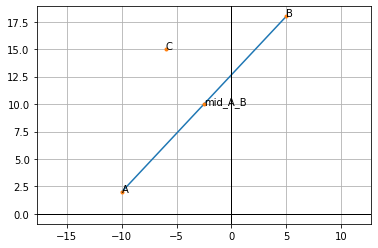

In [13]:
# Points lying on the straight line
A = np.array([-10, 2])
B = np.array([5, 18]) # 18

# a = np.array([2, 2])
# b = np.array([-2, -2])

M = midpoint(A, B)

C = np.array([-6, 15])

points = [A, B, M, C]
lines  = [[A, B]]
labels = ['A', 'B', 'mid_A_B', 'C']

plot(points, lines, labels)

As we can see, the line doesn't pass trough the origin. We have to apply **affine transformation** to shift the whole space, placing **midpoint AB** at (0, 0). If we do so, we can easily find orthogonal projection of the point C on the line spanned by the **B vector**. We can call it **B vector**, because after we shift the space, the segment $|MB|$ becomes a vector as it has its start in the origin.

In [14]:
transform_matrix = np.eye(3)
transform_matrix[0:2, -1] = -M
transform_matrix

array([[  1. ,   0. ,   2.5],
       [  0. ,   1. , -10. ],
       [  0. ,   0. ,   1. ]])

If you'd like to know more details, how to construct the transformation matrix, see for example [Affine Transformation Matrices](https://articulatedrobotics.xyz/5-transformation_matrices/).

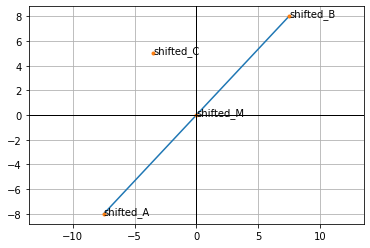

In [15]:
# tranformed_a = affine_transform_matrix @ np.vstack(a.T, [1])
def extend_with_one(vec):
    vec = vec[np.newaxis].T
    return np.vstack([vec, [1]])  

transposed  = [extend_with_one(p) for p in points]
transformed = [transform_matrix @ vec for vec in transposed]
# Removing last dimension with '1'
transformed = [vec[0:2] for vec in transformed]
aff_A, aff_B, aff_M, aff_C = transformed

lines  = [[aff_A, aff_B]]
labels = ['shifted_A', 'shifted_B', 'shifted_M', 'shifted_C']

plot(transformed, lines, labels)

### Projection

In [67]:
dir_vec = (aff_B) / np.linalg.norm(aff_B)
print(dir_vec)
proj_C = (aff_C.T @ dir_vec) / (dir_vec.T @ dir_vec) * dir_vec
proj_C

[[0.68394113]
 [0.7295372 ]]


array([[0.85758836],
       [0.91476091]])

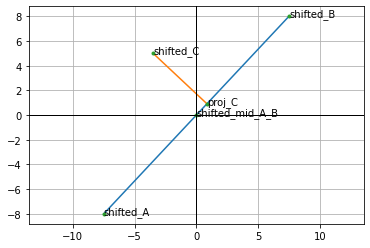

In [18]:
# Plot 
points = transformed + [proj_C]
lines  = [[aff_A, aff_B], [aff_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_mid_A_B', 'shifted_C', 'proj_C']
plot(points, lines, labels)

In [19]:
dist = np.linalg.norm(proj_C)
dist_to_A = np.linalg.norm(proj_C - aff_A)
dist_to_B = np.linalg.norm(proj_C - aff_B)
sign = 1 if dist_to_B < dist_to_A else -1
value = sign * dist
value

1.2538920696157714

## Axis class

Rewriting all as a function

In [184]:
class axis:
    
    def __init__(self, negative_pole, positive_pole):
        
        self.dims = len(negative_pole)
        
        # Original values
        self.A = negative_pole 
        self.B = positive_pole
        self.M = midpoint(negative_pole, positive_pole)  
        
        # Transformation
        self.transform = self.transformation_matrix(self.M)       
        self.shifted_A = self.shift(negative_pole)
        self.shifted_B = self.shift(positive_pole)
        
        self.direction = self.shifted_B / np.linalg.norm(self.shifted_B)
        # shifted_M is (0, 0, ...)
    
    def extend_with_one(self, V):
        V = V[np.newaxis].T
        return np.vstack([V, [1]])      
    
    def transformation_matrix(self, M):
        mat = np.eye(self.dims + 1)
        mat[0:self.dims, -1] = -M
        return mat   
    
    def shift(self, V):
        return (self.transform @ self.extend_with_one(V))[0:self.dims]
    
    def project(self, V):
        shifted_V = self.shift(V)
        return (shifted_V.T @ self.direction) / (self.direction.T @ self.direction) * self.direction
   
    def __call__(self, V):
        proj_V = self.project(V)
        dist = np.linalg.norm(proj_V)
        dist_to_A = np.linalg.norm(proj_V - self.shifted_A)
        dist_to_B = np.linalg.norm(proj_V - self.shifted_B)
        sign = 1 if dist_to_B < dist_to_A else -1
        value = sign * dist
        return value

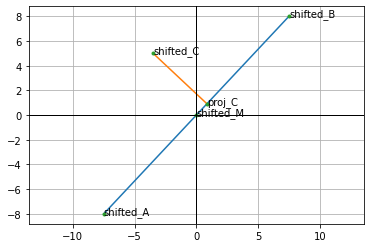

In [192]:
# Points lying on the straight line
A = np.array([-10, 2])
B = np.array([5, 18]) # 18
C = np.array([-6, 15])

axis_a_b = axis(A, B)

points = [A, B, C, axis_a_b.M]
shifted_points = [axis_a_b.shift(p) for p in points]
proj_C = axis_a_b.project(C)
shifted_points = shifted_points + [proj_C]

shifted_A, shifted_B, shifted_C, shifted_M, _  = shifted_points

lines  = [[shifted_A, shifted_B], [shifted_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_C', 'shifted_M', 'proj_C']
plot(shifted_points, lines, labels)

## Experiment with embeddings

In [91]:
ice_fire_axis = axis(ice.vector, fire.vector)

In [213]:
# Ice
ice_value = ice_fire_axis(ice.vector)

# Fire
fire_value = ice_fire_axis(fire.vector)

In [228]:
cold = ['ice cream', 'polar', 'snow', 'winter', 'fridge', 'Antarctica']
warm = ['boiling water', 'tropical', 'sun', 'summer', 'oven', 'Africa']

In [229]:
cold_vecs = [nlp(w).vector for w in cold]
warm_vecs = [nlp(w).vector for w in warm]

In [230]:
cold_values = [ice_fire_axis(p) for p in cold_vecs]
warm_values = [ice_fire_axis(p) for p in warm_vecs]

In [231]:
all_values = cold_values + warm_values + [ice_value, fire_value]
all_labels = cold + warm

# See: 
# * https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/timeline.html
# * https://parulpandey.com/2020/08/17/advanced-plots-in-matplotlib%E2%80%8A-%E2%80%8Apart-2/

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.set(title="Word embedding vectors")

ax.plot(all_values, np.zeros_like(all_values), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# Warm values
warm_levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(warm_values)/6)))[:len(warm_values)]

ax.vlines(warm_values, 0, warm_levels, color="tab:red")  
 
warm_vert = np.array(['top', 'bottom'])[(warm_levels > 0).astype(int)]

for d, l, r, va in zip(warm_values, warm_levels, warm, warm_vert):
    ax.annotate(r, xy=(d, l), xytext=(1, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")
    
# Cold values
cold_levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(cold_values)/6)))[:len(cold_values)]
ax.vlines(cold_values, 0, cold_levels, color="tab:blue")  
cold_vert = np.array(['top', 'bottom'])[(cold_levels > 0).astype(int)]

for d, l, r, va in zip(cold_values, cold_levels, cold, cold_vert):
    ax.annotate(r, xy=(d, l), xytext=(1, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# Addings "poles"
ax.vlines(fire_value, 0, 4, color="red")  
ax.annotate("fire", xy=(fire_value, 4), xytext=(4, np.sign(4)*3),
            textcoords="offset points", va=va, ha="right", weight='bold')

ax.vlines(ice_value, 0, 4, color="blue")  
ax.annotate("ice", xy=(ice_value, 4), xytext=(4, np.sign(4)*3),
            textcoords="offset points", va=va, ha="right", weight='bold')
    
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

## Conclusions

As we can see, in this case the meaning of the distance between "ice" and "fire" looks as expected. "Cold words" are closer to the *negative pole* while the "warm words* - to the *positive pole*.